In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
wine_data_path = "../data/winemag-data-130k-v2.csv" 

In [3]:
missing_values = ["n/a", "na", "--"]
raw_wine_data = pd.read_csv(wine_data_path, na_values = missing_values)

def get_year(string, list):
    for word in string.split():
        if word.isdigit():
            list.append(word)
            return True

    list.append('NaN')
    return False

raw_wine_data.sample(5)

years = []
raw_wine_data['title'].apply(lambda x: get_year(x, years))
raw_wine_data['year'] = years

raw_wine_data['description_length'] = raw_wine_data['description'].apply(lambda x: len(str(x).split(" ")))
raw_wine_data = raw_wine_data[raw_wine_data['description_length'] > 6]
raw_wine_data.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,description_length
68915,68915,Spain,Aromas of spiced applesauce and minerals mark ...,Spring in a Bottle,86,18.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Verderol 2014 Spring in a Bottle Verdejo (Rueda),Verdejo,Verderol,2014,32
55153,55153,Spain,"Rusty in color, with soft aromas of cherry and...",Rosado Brut,87,18.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,Mont Marçal 2013 Rosado Brut Trepat (Cava),Trepat,Mont Marçal,2013,31
91644,91644,US,"From the Palindrome Vineyard, this meaty red i...",NaN,91,36.0,California,Dry Creek Valley,Sonoma,Virginie Boone,@vboone,Inspiration 2014 Syrah (Dry Creek Valley),Syrah,Inspiration,2014,47
20008,20008,Argentina,Brandied cherry aromas are a touch stalky and ...,Roble Oak,86,11.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Bodega Privada 2012 Roble Oak Cabernet Sauvign...,Cabernet Sauvignon,Bodega Privada,2012,34
15362,15362,US,Ripe cherry and raspberry aromas are accented ...,Long Bomb Edition Six,86,20.0,Virginia,Virginia,NaN,NaN,NaN,Tarara 2012 Long Bomb Edition Six Red (Virginia),Red Blend,Tarara,2012,31


In [4]:
list(raw_wine_data)

['Unnamed: 0',
 'country',
 'description',
 'designation',
 'points',
 'price',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'taster_twitter_handle',
 'title',
 'variety',
 'winery',
 'year',
 'description_length']

### Wineries
Plot of the scores of wines of different wineries in the 2 most reviewed regions. This didn't result in a particular interesting result.

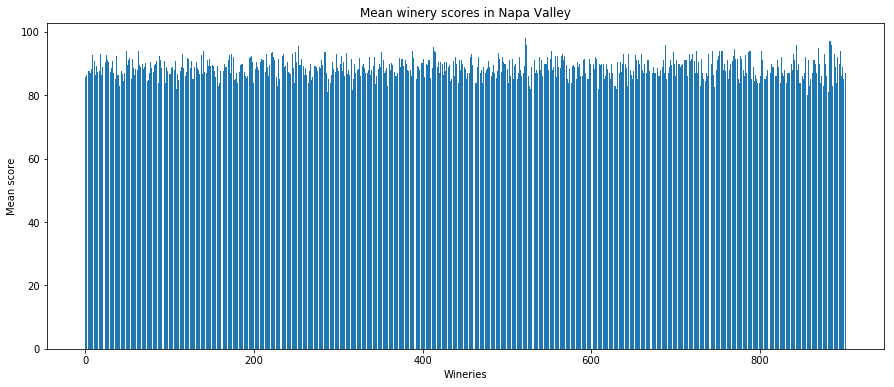

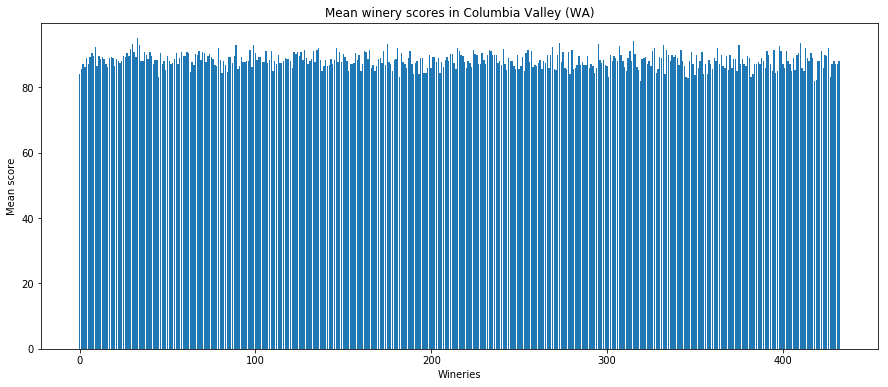

In [17]:
most_occuring_region = raw_wine_data["region_1"].value_counts().idxmax()
region_wines = raw_wine_data[raw_wine_data["region_1"] == most_occuring_region]

wine_houses = region_wines["winery"].value_counts()

wine_houses = region_wines["winery"].unique()

all_house_scores = []

for house in wine_houses:
    house_scores = region_wines[region_wines["winery"] == house]["points"].values
    if len(house_scores) > 0:
        all_house_scores.append(house_scores)

mean_house_scores = []
for scores in all_house_scores:
    scores[np.isnan(scores)] = 0
    mean_house_scores.append(np.mean(scores))

plt.figure(figsize=(15, 6))
plt.bar(range(len(mean_house_scores)), mean_house_scores)
plt.xlabel("Wineries")
plt.ylabel("Mean score")
plt.title("Mean winery scores in " + most_occuring_region)
plt.show()

most_occuring_region = "Columbia Valley (WA)"

region_wines = raw_wine_data[raw_wine_data["region_1"] == most_occuring_region]

wine_houses = region_wines["winery"].unique()

all_house_scores = []

for house in wine_houses:
    house_scores = region_wines[region_wines["winery"] == house]["points"].values
    all_house_scores.append(house_scores)

mean_house_scores = []
for scores in all_house_scores:
    scores[np.isnan(scores)] = 0
    mean_house_scores.append(np.mean(scores))

plt.figure(figsize=(15, 6))
plt.bar(range(len(mean_house_scores)), mean_house_scores)
plt.xlabel("Wineries")
plt.ylabel("Mean score")
plt.title("Mean winery scores in " + most_occuring_region)
plt.show()

### Feature selection
Feature selection is done here on multiple columns. The columns are selected which didn't result in the amount of columns growing too large. If they did result in too many columns, the features couldn't be selected due to limited memory. Feature selection is done with mutual information as a score, since this is a measure of the dependency of two variables.

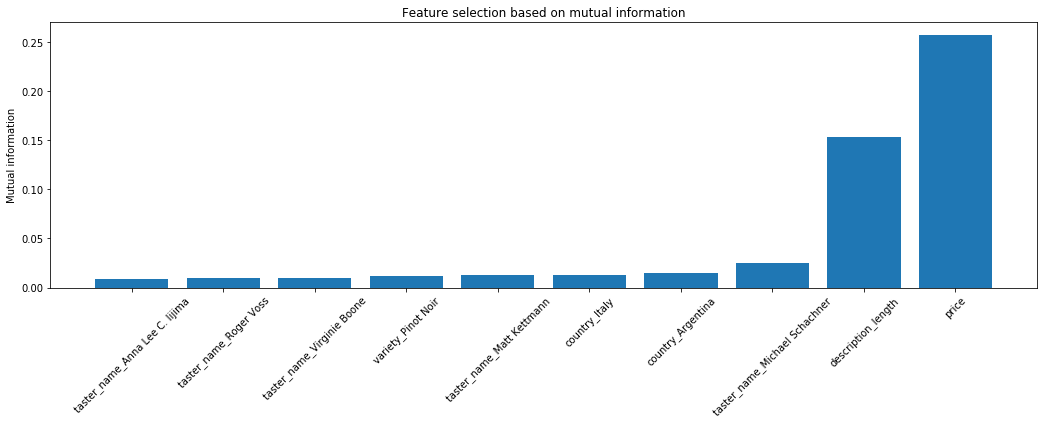

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

temp_wine_data = raw_wine_data.copy()

dropped_data = temp_wine_data.drop(['province', 'title', 'winery', 'designation', 'Unnamed: 0', 'description', 'region_2', 'taster_twitter_handle', 'title'], axis=1).dropna()

# Translate data through dummy encoding (one-hot encoding).
dumm_data = pd.get_dummies(dropped_data)
dumm_data_points = dumm_data.points
dumm_data = dumm_data.drop(['points'], axis=1)

# Fit features by taking the 10 best scores.
test = SelectKBest(score_func=mutual_info_classif, k=10)
fit = test.fit(dumm_data, dumm_data_points)

# Filter and sort labels and scores for the plot.
labels = dumm_data.columns[fit.get_support(indices=True)]
scores = fit.scores_[fit.get_support(indices=True)]
pairs = zip(labels, scores)

sorted_pairs = sorted(pairs, key=lambda t: t[1])
sorted_labels = list(zip(*sorted_pairs))[0]
sorted_scores = list(zip(*sorted_pairs))[1]
xs = [i for i in range(len(sorted_labels))]

plt.figure(figsize=(15, 6))

plt.xticks(xs, sorted_labels)
plt.tick_params(axis='x', rotation=45)
plt.title("Feature selection based on mutual information")
plt.ylabel("Mutual information")
plt.tight_layout()
plt.bar(xs, sorted_scores)
plt.savefig("../figures/feature_selection/Feature_selection")
plt.show()